In [123]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [124]:
df = pd.read_csv("flo_data_20k.csv")

#############################################
# 1. Genel Resim
#############################################

In [125]:

def check_df(dataframe, head=5, tail=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(tail))
    print("##################### Unique #####################")
    print(dataframe.nunique())
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel  \
0  cc294636-19f0-11eb-8d74-000d3a38a36f   Android App            Offline   
1  f431bd5a-ab7b-11e9-a2fc-000d3a38a36f   Android App             Mobile   
2  69b69676-1a40-11ea-941b-000d3a38a36f   Android App    

#############################################
# tarih değişkenine çevirme
#############################################

In [126]:
date_columns = df.columns[df.columns.str.contains("date")]
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [127]:
df["last_order_date"].max()
analysis_date = dt.datetime(2023,11,2)

 # en son kaç gün önce alışveriş yaptı

In [128]:
df["recency"] = (analysis_date - df["last_order_date"]).astype('timedelta64[D]')

# Müşteri yaşı

In [129]:
df["tenure"] = (df["last_order_date"]-df["first_order_date"]).astype('timedelta64[D]')

In [130]:
model_df = df[["order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,4.0,1.0,139.99,799.38,979.0,119.0
1,19.0,2.0,159.97,1853.58,989.0,1469.0
2,3.0,2.0,189.97,395.35,1070.0,366.0
3,1.0,1.0,39.99,81.98,1019.0,11.0
4,1.0,1.0,49.99,159.99,970.0,582.0


# Scaling

In [131]:
sc = MinMaxScaler((0, 1))
model_scaling = sc.fit_transform(model_df)
model_df=pd.DataFrame(model_scaling,columns=model_df.columns)
model_df.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure
0,0.015075,0.000000,0.007178,0.017395,0.254795,0.039222
1,0.090452,0.009259,0.008281,0.040715,0.282192,0.484179
2,0.010050,0.009259,0.009938,0.008458,0.504110,0.120633
3,0.000000,0.000000,0.001656,0.001526,0.364384,0.003626
4,0.000000,0.000000,0.002208,0.003252,0.230137,0.191826


# Optimum küme sayısını belirleme

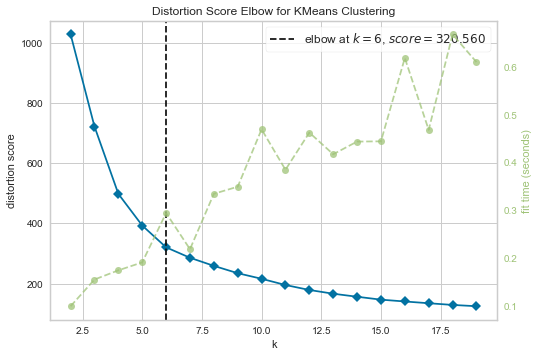

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [132]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(model_df)
elbow.show()

# Modelinizi oluşturma

In [133]:
k_means = KMeans(n_clusters = 7, random_state= 42).fit(model_df)
segments=k_means.labels_
segments

array([2, 4, 0, ..., 1, 2, 5])

# Kümeleri veriye ekledik.

In [134]:
final_df = df[["master_id","order_num_total_ever_online","order_num_total_ever_offline","customer_value_total_ever_offline","customer_value_total_ever_online","recency","tenure"]]
final_df["segment"] = segments
final_df.head()

,master_id,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,recency,tenure,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,4.0,1.0,139.99,799.38,979.0,119.0,2
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,19.0,2.0,159.97,1853.58,989.0,1469.0,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,3.0,2.0,189.97,395.35,1070.0,366.0,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.0,1.0,39.99,81.98,1019.0,11.0,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,1.0,1.0,49.99,159.99,970.0,582.0,2


# Herbir segment istatistiksel olarak.

In [135]:
final_df.groupby("segment").agg({"order_num_total_ever_online":["mean","min","max"],
                                  "order_num_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_offline":["mean","min","max"],
                                  "customer_value_total_ever_online":["mean","min","max"],
                                  "recency":["mean","min","max"],
                                  "tenure":["mean","min","max","count"]})

order_num_total_ever_online             order_num_total_ever_offline  \
                               mean  min    max                         mean   
segment                                                                        
0                          2.329218  1.0   28.0                     1.770062   
1                          2.914406  1.0   66.0                     1.985678   
2                          2.291685  1.0   30.0                     1.948260   
3                          8.073722  1.0  200.0                     2.143876   
4                          6.246345  1.0   69.0                     2.076023   
5                          2.044153  1.0   20.0                     1.741448   
6                          5.216855  1.0   55.0                     1.913669   

                    customer_value_total_ever_offline                   \
         min    max                              mean    min       max   
segment                                                                  
0        1.0  109.0                        232.104254  10.49  10239.46   
1        1.0   81.0                        272.879833  12.99  18119.14   
2        1.0   74.0                        257.293041  11.98   7247.60   
3        1.0   24.0                        287.257134  12.99   3215.78   
4        1.0   36.0                        274.307902  12.99   3589.65   
5        1.0   87.0                        216.467697  10.00   8432.25   
6        1.0   16.0                        249.442754  12.99   1811.54   

        customer_value_total_ever_online                       recency  \
                                    mean    min       max         mean   
segment                                                                  
0                             391.995764  18.74  12038.18  1086.244342   
1                             523.438607  19.99  30688.47   914.850885   
2                             381.690789  14.00   8667.73   994.731134   
3                            1076.770713  19.99  45220.13   956.568371   
4                             899.705439  19.99  36687.80   957.614766   
5                             330.787892  12.99   7665.28  1204.003580   
6                             648.579702  14.99   7133.14  1147.130524   

                              tenure                        
            min     max         mean     min     max count  
segment                                                     
0        1041.0  1150.0   458.363426     0.0  1245.0  3888  
1         886.0   958.0   538.316596     0.0  1089.0  5935  
2         949.0  1040.0   464.437189     0.0  1053.0  4426  
3         886.0  1081.0  2210.612366  1753.0  3034.0   841  
4         886.0  1058.0  1305.260965   841.0  1760.0  1368  
5        1143.0  1251.0   380.672235     0.0  1245.0  2514  
6        1049.0  1251.0  1712.082220   985.0  2820.0   973